# PREPROCESSING

In [18]:
import cv2
import numpy as np

def preprocess(image):
    image_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_resized = cv2.resize(image_np, (640, 640))
    return image_resized

In [19]:
import cv2
import numpy as np

def preprocess_for_ocr(image_np):
    # Ubah ke grayscale
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    # Denoising
    denoised = cv2.fastNlMeansDenoising(gray, h=8)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        9, 3
    )

    return thresh

# OBJECT DETECTION MODEL

In [20]:
!pip install ultralytics

In [21]:
from ultralytics import YOLO

model = YOLO("/kaggle/input/yolo_detect/other/default/1/best.pt")

In [22]:
def process_model(image):
    image_resized = preprocess(image)
    results = model(image_resized)[0]  # Ambil hasil pertama
    boxes = results.boxes  # Bounding box predictions

    bboxes = boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    classes = boxes.cls.cpu().numpy().astype(int)  # Class index (int)

    # print(f"class: {classes}")
    # print(f"BOX: {bboxes}")
    
    return bboxes, classes

# OCR

In [23]:
# label_map = {
#     0: 'table',
#     1: 'not_table'
# }

label_map = {
    0: 'item_name',
    1: 'quantity',
    2: 'price',
    3: 'invoice'
}

In [24]:
import re
from typing import List, Dict, Union

def split_detected_text(detected_text: str) -> List[str]:
    """
    Memecah string panjang hasil OCR menjadi list baris berdasarkan pola 'text price'
    Misalnya: "nasi campur 75,ooo ayam 60,ooo" → ["nasi campur 75,ooo", "ayam 60,ooo"]
    """

    # Cari semua potongan yang diakhiri angka (misal 75,000 / 60.000 / 30.0)
    # Asumsikan bahwa item akan memiliki angka di akhir
    pattern = re.compile(r'(.*?\d[\d.,]*)(?=\s+[a-zA-Z]|$)')
    lines = pattern.findall(detected_text)

    # Bersihkan trailing whitespaces
    lines = [line.strip() for line in lines if line.strip()]
    return lines

In [25]:
def extract_multiple_items_from_line(line: str) -> List[Dict[str, Union[str, int]]]:
    """
    Ekstrak pasangan item dan harga dari satu baris teks OCR.
    Menangani multiple item+price dalam satu baris dengan memanfaatkan regex dan heuristik teks sebelumnya.
    """

    # Cari semua harga di baris (format bebas: 3300, 3,300, 3.300, dst)
    matches = list(re.finditer(r'(\d{1,3}(?:[.,]\d{3})+|\d{4,})', line))

    if not matches:
        return []

    items = []
    last_end = 0

    for match in matches:
        price_str = match.group()
        try:
            price = int(price_str.replace(",", "").replace(".", ""))
        except:
            continue

        # Ambil teks sebelum harga sebagai item
        item_text = line[last_end:match.start()].strip()

        # Hindari item kosong atau angka doang
        if item_text and not item_text.replace(" ", "").isdigit():
            items.append({
                "item_name": item_text,
                "price": price
            })

        last_end = match.end()

    return items


def clean_ocr_text(line: str) -> str:
    # Gabungkan angka yang terpisah spasi: "10 0o0" -> "10000"
    line = re.sub(r'(\d)\s+(\d)', r'\1\2', line)

    # Ganti huruf 'o' atau 'O' yang tertulis sebagai nol
    line = line.replace('o', '0').replace('O', '0')

    return line

def detect_class(lines: List[str]) -> List[Dict]:
    processed_results = []

    for line in lines:
        item_price_pairs = extract_multiple_items_from_line(line)
        if item_price_pairs:
            for pair in item_price_pairs:
                processed_results.append({
                    'class': 'item',
                    'text': pair['item_name']  # ← Fix di sini
                })
                processed_results.append({
                    'class': 'price',
                    'price': pair['price']
                })
        else:
            processed_results.append({
                'class': 'item',
                'text': line
            })

    return processed_results

In [26]:
import re
from typing import List, Dict, Union

def reconstruct_items(ner_results: List[Dict]) -> List[Dict]:
    reconstructed = []
    current_item = []
    last_was_item = False
    
    for entry in ner_results:
        if entry['class'] == 'item':
            if not last_was_item and current_item:
                # Jika bertemu item baru, selesaikan item sebelumnya
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            current_item.append(entry['text'])
            last_was_item = True
        else:
            if current_item:
                # Selesaikan item yang sedang dibangun
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            reconstructed.append(entry)  # Tambahkan price/entitas lain
            last_was_item = False
    
    # Tambahkan sisa item jika ada
    if current_item:
        reconstructed.append({
            'class': 'item',
            'text': ' '.join(current_item).strip(),
            'original_parts': current_item.copy()
        })
    
    return reconstructed

def pair_entities(ner_results: List[Dict]) -> List[Dict]:
    """Memasangkan item dan price yang berurutan"""
    paired = []
    i = 0
    n = len(ner_results)
    
    while i < n:
        if ner_results[i]['class'] == 'item':
            item = ner_results[i]['text']
            price = None
            numeric_price = None

            # Cari price berikutnya
            if i + 1 < n and ner_results[i+1]['class'] == 'price':
                price_entry = ner_results[i+1]
                price = price_entry.get('price')  # Akses 'price' jika sudah diganti
                numeric_price = price_entry.get('price')  # Atau akses langsung numeric value

                i += 1  # Lewati price yang sudah diproses
            
            paired.append({
                'item_name': item,
                'price': numeric_price
            })
        i += 1
    
    return paired


def is_noise(text: str) -> bool:
    """
    Mengecek apakah suatu teks termasuk 'noise' (bukan item menu, misalnya total, service, dll)
    """
    noise_keywords = [
        'subtotal', 'sub total', 'service', 'tax', 'pajak', 'pb1', 't0tal', 'subt0tal',
        'r0unding','disk0n','disc0unt',
        'rounding', 'diskon', 'discount', 'total', 'grand total', 'change', 'kembalian', 'srand tl'
    ]
    text = text.lower()
    return any(keyword in text for keyword in noise_keywords)


In [27]:
def process_receipt_data_with_ner(ner_results: List[Dict]) -> Dict:
    """Pipeline utama dengan NER"""
    # 1. Rekonstruksi item multi-kata
    reconstructed = reconstruct_items(ner_results)
    
    # 2. Pasangkan item dengan price
    paired = pair_entities(reconstructed)
    
    # 3. Filter hasil
    valid_items = [
        item for item in paired 
        if item['item_name'] and item['price'] and not is_noise(item['item_name'])
    ]
    
    return {
        'status': 'success',
        'items': valid_items
    }

In [28]:
import easyocr
import numpy as np
import cv2
import os

# Inisialisasi
keywords = ['total', 'subtotal', 'amount', 'jumlah', 't0tal', 'subt0tal']
reader = easyocr.Reader(['en', 'id']) 

def crop_image_by_bbox(image: np.ndarray, bbox: list) -> np.ndarray:
    height, width = image.shape[:2]

    if len(bbox) == 4:
        x_min, y_min, x_max, y_max = bbox
        x_min = int(max(0, min(x_min, width - 1)))
        x_max = int(max(0, min(x_max, width - 1)))
        y_min = int(max(0, min(y_min, height - 1)))
        y_max = int(max(0, min(y_max, height - 1)))

        cropped_image = image[y_min:y_max, x_min:x_max]
        return cropped_image

    elif len(bbox) == 8:
        pts = np.array(bbox, dtype=np.float32).reshape(-1, 2)
        dst_pts = np.array([[0, 0], [639, 0], [639, 639], [0, 639]], dtype=np.float32)
        matrix = cv2.getPerspectiveTransform(pts, dst_pts)
        cropped_image = cv2.warpPerspective(image, matrix, (640, 640))
        return cropped_image

    else:
        raise ValueError("Format bbox tidak valid.")

    
def read_image(image):
    preprocessed = preprocess(image)

    boxes, classes = process_model(preprocessed)

    print("Langsung cek keyword dari OCR global...")

    preprocessed_ocr = preprocess_for_ocr(preprocessed)
    ocr_result = reader.readtext(preprocessed_ocr)
    detected_lines = [text for _, text, _ in ocr_result]
    detected_text_lower = " ".join([t.lower() for t in detected_lines])
    # print(f"cek keyword: {detected_text_lower}")

    # Cek apakah ada keyword di teks hasil OCR
    if any(keyword in detected_text_lower for keyword in keywords):
        print("Keyword ditemukan. Proses ekstraksi data receipt...")

        #OCR berdasarkan bbox dari hasil deteksi model
        detected_lines = []
        
        for idx, bbox in enumerate(boxes):
            try:
                cropped_image = crop_image_by_bbox(preprocessed_ocr, bbox)
                ocr_result = reader.readtext(cropped_image)
        
                # Ambil teks saja dari hasil OCR
                detected_lines.extend([text for _, text, _ in ocr_result])
        
            except ValueError as e:
                print(f"Error dalam cropping gambar: {e}")
                continue

        detected_text_lower = " ".join([t.lower() for t in detected_lines])
        print(detected_text_lower)
        
        lines = split_detected_text(detected_text_lower)
        ner_results = detect_class(lines)
        final_result = process_receipt_data_with_ner(ner_results)
        
        # Output
        print("SPLIT lines:", lines)
        print("NER results:", ner_results)
        print("FINAL:", final_result)

        return final_result

    print("Tidak ada keyword penting ditemukan. Gambar bukan receipt/invoice.")
    return {
        "status": "not_receipt_invoice",
        "error_msg": "Gambar yang Anda masukkan bukan receipt/invoice."
    }

# TEST

In [29]:
def crop_and_save(image, boxes, output_folder="cropped_images", prefix="img"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for idx, bbox in enumerate(boxes):
        try:
            save_path = os.path.join(output_folder, f"{prefix}_crop_{idx}.jpg")
            crop_image_by_bbox(image, bbox, save_path)
        except ValueError as e:
            print(f"Cropping gagal: {e}")

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_boxes_safe(image, boxes, classes, label_map, save_path='output_with_boxes.jpg'):
    image = preprocess(image)
    preprocessed_ocr = preprocess_for_ocr(image)
    image_vis = preprocessed_ocr.copy()
    height, width = preprocessed_ocr.shape[:2]

    for box, cls_id in zip(boxes, classes):
        cls_name = label_map[int(cls_id)]
        color = (0, 255, 0)
        thickness = 2

        try:
            if len(box) == 4:
                # Box = [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)
                x1 = max(0, min(x1, width - 1))
                x2 = max(0, min(x2, width - 1))
                y1 = max(0, min(y1, height - 1))
                y2 = max(0, min(y2, height - 1))
                cv2.rectangle(image_vis, (x1, y1), (x2, y2), color, thickness)
                cv2.putText(image_vis, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            elif len(box) == 8:
                # Box = quadrilateral [x1, y1, x2, y2, x3, y3, x4, y4]
                pts = np.array(box, dtype=np.int32).reshape(-1, 2)
                pts[:, 0] = np.clip(pts[:, 0], 0, width - 1)
                pts[:, 1] = np.clip(pts[:, 1], 0, height - 1)
                cv2.polylines(image_vis, [pts], isClosed=True, color=color, thickness=2)
                cv2.putText(image_vis, cls_name, tuple(pts[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        except Exception as e:
            print(f"Gagal menggambar box: {box}, error: {e}")
            continue

    # Simpan dan tampilkan
    cv2.imwrite(save_path, image_vis)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
    plt.title("Detected BBoxes")
    plt.axis("off")
    plt.show()


In [31]:
# from datasets import load_dataset
# import numpy as np

# # Load dataset split
# dataset_hf = load_dataset("naver-clova-ix/cord-v2", split="test")

In [32]:
# import os
# from roboflow import Roboflow

# print("📦 Mengunduh dataset dari Roboflow...")

# # Inisialisasi Roboflow API
# rf = Roboflow(api_key="QYJz4fQRw4AUwlR6v8Wm")

# # Akses project dan versinya
# project_invoice = rf.workspace("helmetproject-vmo6o").project("invoice-pr8ex")
# version_invoice = project_invoice.version(1)

# # Unduh dataset dalam format YOLOv8
# dataset_path = version_invoice.download("yolov8")  # default ke /kaggle/working/invoice-1
# print(f"✅ Dataset berhasil diunduh ke: {dataset_path.location}")

# # Path ke folder test
# test_path = os.path.join(dataset_path.location, "test")
# print(f"📂 Folder test set tersedia di: {test_path}")

# # Cek isi test folder
# print("📄 File dalam test set:")
# print(os.listdir(test_path))

In [33]:
# from datasets import load_dataset
# import numpy as np
# import os
# from PIL import Image
# import cv2

# # === Bagian 2: Load dataset Roboflow (YOLOv8 format) ===
# roboflow_path = "/kaggle/working/invoice-1/test/images"  # Sesuaikan dengan path kamu
# image_files_rf = [os.path.join(roboflow_path, f) for f in os.listdir(roboflow_path) if f.endswith(('.jpg', '.png'))]
# print(f"🔍 Jumlah data dari Roboflow: {len(image_files_rf)}")

# # === Gabungkan jadi satu list gambar ===
# image_sources = []

# # Tambahkan dari Hugging Face (dalam format PIL)
# for i in range(len(dataset_hf)):
#     image_sources.append({
#         "source": "huggingface",
#         "image": dataset_hf[i]['image']
#     })

# # Tambahkan dari Roboflow (baca dari path sebagai PIL.Image)
# for file_path in image_files_rf:
#     image_sources.append({
#         "source": "roboflow",
#         "image": Image.open(file_path).convert("RGB")
#     })

# print(f"📦 Total gambar digabung: {len(image_sources)}")

# # === Proses semua gambar ===
# for i, data in enumerate(image_sources):
#     print(f"\n--- Gambar ke-{i+1} ({data['source']}) ---")
    
#     image_pil = data['image']
#     image_np = np.array(image_pil)

#     # 1. Model deteksi objek
#     boxes, classes = process_model(image_np)

#     # 2. Visualisasi (opsional)
#     visualize_boxes_safe(image_np, boxes, classes, label_map)

#     # 3. OCR
#     result = read_image(image_np)
#     print(f"📃 OCR: {result}")



--- Gambar ke-1 (contoh-2.jpeg) ---

0: 640x640 2 item_names, 1 quantity, 174.1ms
Speed: 3.1ms preprocess, 174.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


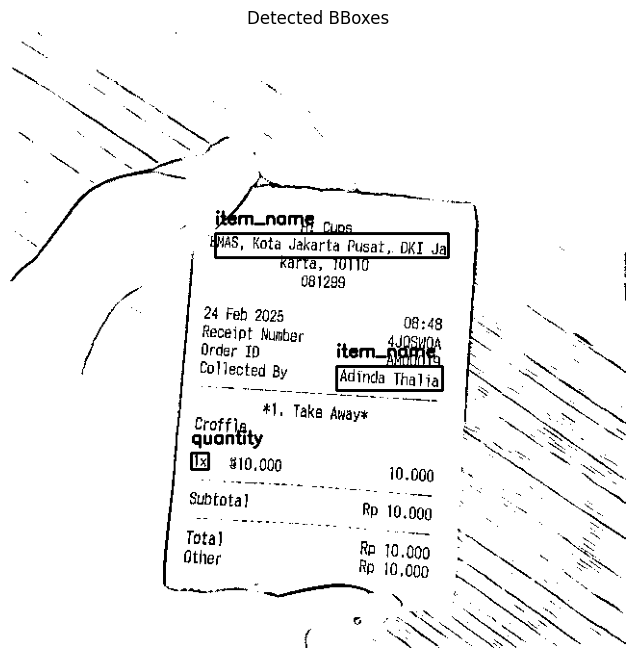


0: 640x640 4 item_names, 2 quantitys, 208.5ms
Speed: 2.7ms preprocess, 208.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
mas _ kota jakarta pusat _ dki ja adinca   thatia coljected by 24 feb 2025
SPLIT lines: ['mas _ kota jakarta pusat _ dki ja adinca   thatia coljected by 24', 'feb 2025']
NER results: [{'class': 'item', 'text': 'mas _ kota jakarta pusat _ dki ja adinca   thatia coljected by 24'}, {'class': 'item', 'text': 'feb'}, {'class': 'price', 'price': 2025}]
FINAL: {'status': 'success', 'items': [{'item_name': 'mas _ kota jakarta pusat _ dki ja adinca   thatia coljected by 24 feb', 'price': 2025}]}
📃 OCR: {'status': 'success', 'items': [{'item_name': 'mas _ kota jakarta pusat _ dki ja adinca   thatia coljected by 24 feb', 'price': 2025}]}

--- Gambar ke-2 (contoh-4.jpeg) ---

0: 640x640 3 prices, 162.7ms
Speed: 2.5ms preprocess, 162.7ms inference, 1.4ms postprocess

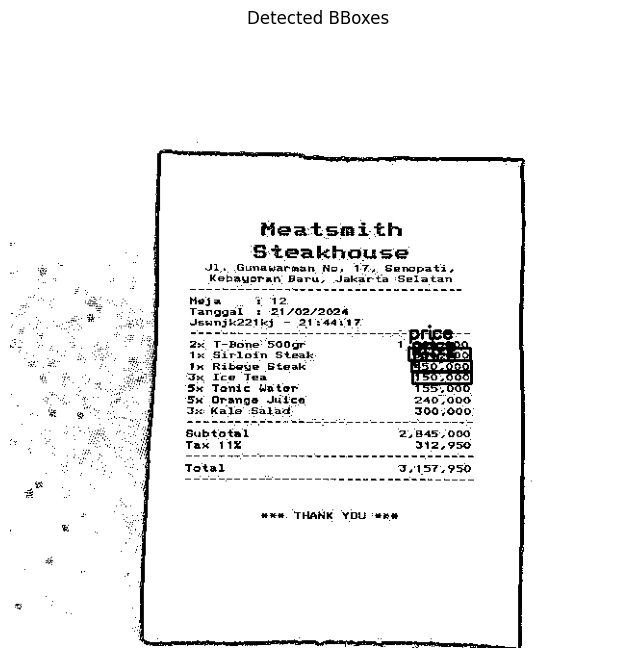


0: 640x640 (no detections), 163.9ms
Speed: 2.5ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...

SPLIT lines: []
NER results: []
FINAL: {'status': 'success', 'items': []}
📃 OCR: {'status': 'success', 'items': []}

--- Gambar ke-3 (contoh-3.jpeg) ---

0: 640x640 10 item_names, 4 quantitys, 4 prices, 165.5ms
Speed: 2.3ms preprocess, 165.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


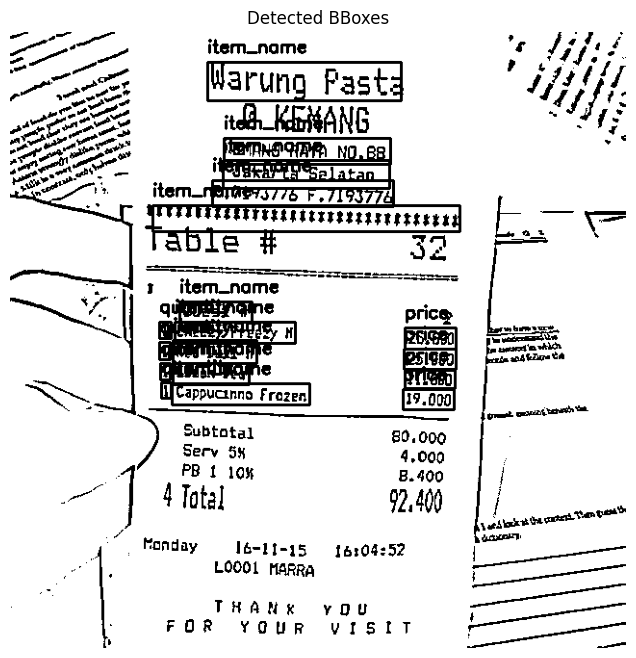


0: 640x640 11 item_names, 4 quantitys, 4 prices, 173.6ms
Speed: 2.8ms preprocess, 173.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
11.000 19.000 25.000 25.000 cappucnno frozen cuest levon tej red dull cheezy frpezy 19j776 f,7i9j776 warung fast jakarta selatan ietang raya no.88 ttt tuutttnttt o21acav p,7193776 f,719j776
SPLIT lines: ['11.000 19.000 25.000 25.000', 'cappucnno frozen cuest levon tej red dull cheezy frpezy 19j776', 'f,7i9j776', 'warung fast jakarta selatan ietang raya no.88', 'ttt tuutttnttt o21acav p,7193776', 'f,719j776']
NER results: [{'class': 'item', 'text': '11.000 19.000 25.000 25.000'}, {'class': 'item', 'text': 'cappucnno frozen cuest levon tej red dull cheezy frpezy 19j776'}, {'class': 'item', 'text': 'f,7i9j776'}, {'class': 'item', 'text': 'warung fast jakarta selatan ietang raya no.88'}, {'class': 'item', 'text': 'ttt tuutttnttt o21acav p,'}, {'c

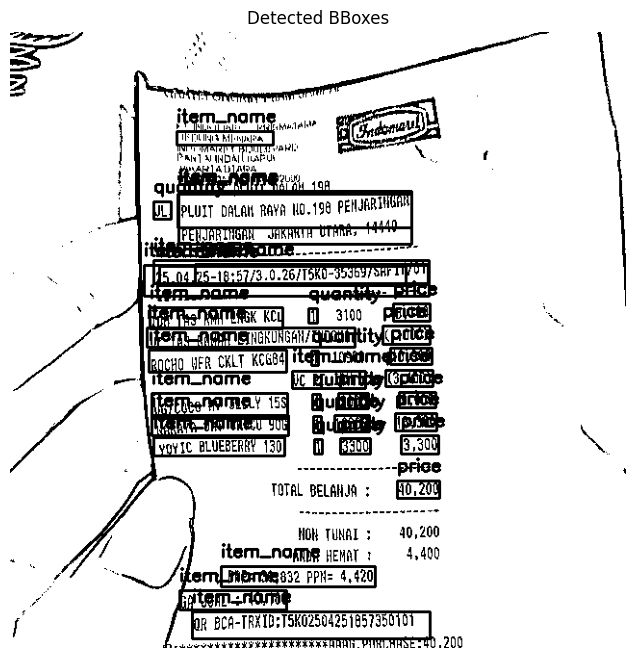


0: 640x640 19 item_names, 6 quantitys, 10 prices, 172.2ms
Speed: 2.7ms preprocess, 172.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
18,300 3,100 3,300 10,900 9,006 (1,000) (3,400) uic tes rrhah ihgkungah / ihdoha rocho hfr cklt kcg84 hg/coco hy jelly 15s 75-18:57/3 26 /tsko-35369 /safit/41 vc pt ibh harrya oat choco 906 25.04.25-18:57/3 .0.26/t5k0-35369 /shf _ pluit  dala raya h0.190 pehjarihgan   jakarta utara, 14440 pehjarihgan 25.04.75-18;57/3.0.26/tsk0-35369/saf it /01 ibm tas rmh lhsk kcl 25.04.25-18:57/3.0.26/tsk0-35864/ shr11- yoyic blueberby 130 pluit  dalai rayn ho,190 pehjar lhbhn 3300 ull mll"^ dpp: 36,832 pph: 420 18300 qr bca-trxid:tsko2504251057350101 900 '8282""88l8 190 6a  jval 40, /80 plvit dalaii raya h0 .190 penji
SPLIT lines: ['18,300 3,100 3,300 10,900 9,006 (1,000) (3,400) uic tes rrhah ihgkungah / ihdoha rocho hfr cklt kcg84', 'hg/coco hy jelly 15s

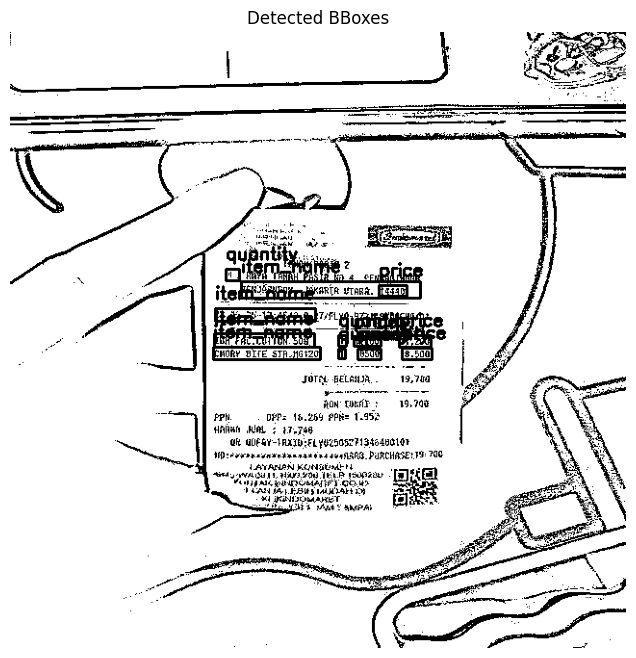


0: 640x640 3 item_names, 4 quantitys, 5 prices, 175.2ms
Speed: 3.5ms preprocess, 175.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Tidak ada keyword penting ditemukan. Gambar bukan receipt/invoice.
📃 OCR: {'status': 'not_receipt_invoice', 'error_msg': 'Gambar yang Anda masukkan bukan receipt/invoice.'}


In [34]:
import os
from PIL import Image
import numpy as np

# Path ke folder gambar
folder_path = "/kaggle/input/test-image"

# Dapatkan daftar file gambar dengan ekstensi tertentu
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for i, filename in enumerate(image_files):
    image_path = os.path.join(folder_path, filename)
    try:
        # Buka gambar dan konversi ke array NumPy
        image_pil = Image.open(image_path).convert("RGB")
        image_np = np.array(image_pil)

        print(f"\n--- Gambar ke-{i+1} ({filename}) ---")

        # 1. Model deteksi objek
        boxes, classes = process_model(image_np)

        # 2. Visualisasi (opsional)
        visualize_boxes_safe(image_np, boxes, classes, label_map)

        # 3. OCR
        result = read_image(image_np)
        print(f"📃 OCR: {result}")

    except Exception as e:
        print(f"❌ Gagal memproses {filename}: {e}")